<a href="https://colab.research.google.com/github/vijjus/CV/blob/master/denoising_autoencoder_image_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile, os, cv2
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.nn import MSELoss
from torch.optim import SGD

import imgaug as ia
from imgaug import augmenters as iaa

sns.set_style('darkgrid')

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!cp /content/gdrive/MyDrive/denoising-dirty-documents.zip .

In [4]:
!unzip -qf denoising-dirty-documents.zip

In [5]:
!unzip -qf train.zip

In [6]:
!unzip -qf train_cleaned.zip

In [7]:
!unzip -qf test.zip

In [8]:
!ls

denoising-dirty-documents.zip  test	      train_cleaned.zip
gdrive			       test.zip       train.zip
sample_data		       train
sampleSubmission.csv.zip       train_cleaned


# Data Preparation

In [9]:
train_img = sorted(os.listdir('train'))
train_cleaned_img = sorted(os.listdir('train_cleaned'))
test_img = sorted(os.listdir('test'))

In [10]:
class config():
    IMG_SIZE = (420, 540)

imgs = [cv2.imread('train/' + f) for f in sorted(os.listdir('train/'))]
print('Median Dimensions:', np.median([len(img) for img in imgs]), np.median([len(img[0]) for img in imgs]))
del imgs

Median Dimensions: 420.0 540.0


In [11]:
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, config.IMG_SIZE[::-1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (*config.IMG_SIZE, 1))
    
    return img

In [12]:
train = []
train_cleaned = []
test = []
path = "./"
for f in sorted(os.listdir(path + 'train/')):
    train.append(process_image(path + 'train/' + f))

for f in sorted(os.listdir(path + 'train_cleaned/')):
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))
    
for f in sorted(os.listdir(path + 'test/')):
    test.append(process_image(path + 'test/' + f))
    
train = np.asarray(train)
train_cleaned = np.asarray(train_cleaned)
test = np.asarray(test)

In [13]:
train.shape, train_cleaned.shape, test.shape

((144, 420, 540, 1), (144, 420, 540, 1), (72, 420, 540, 1))

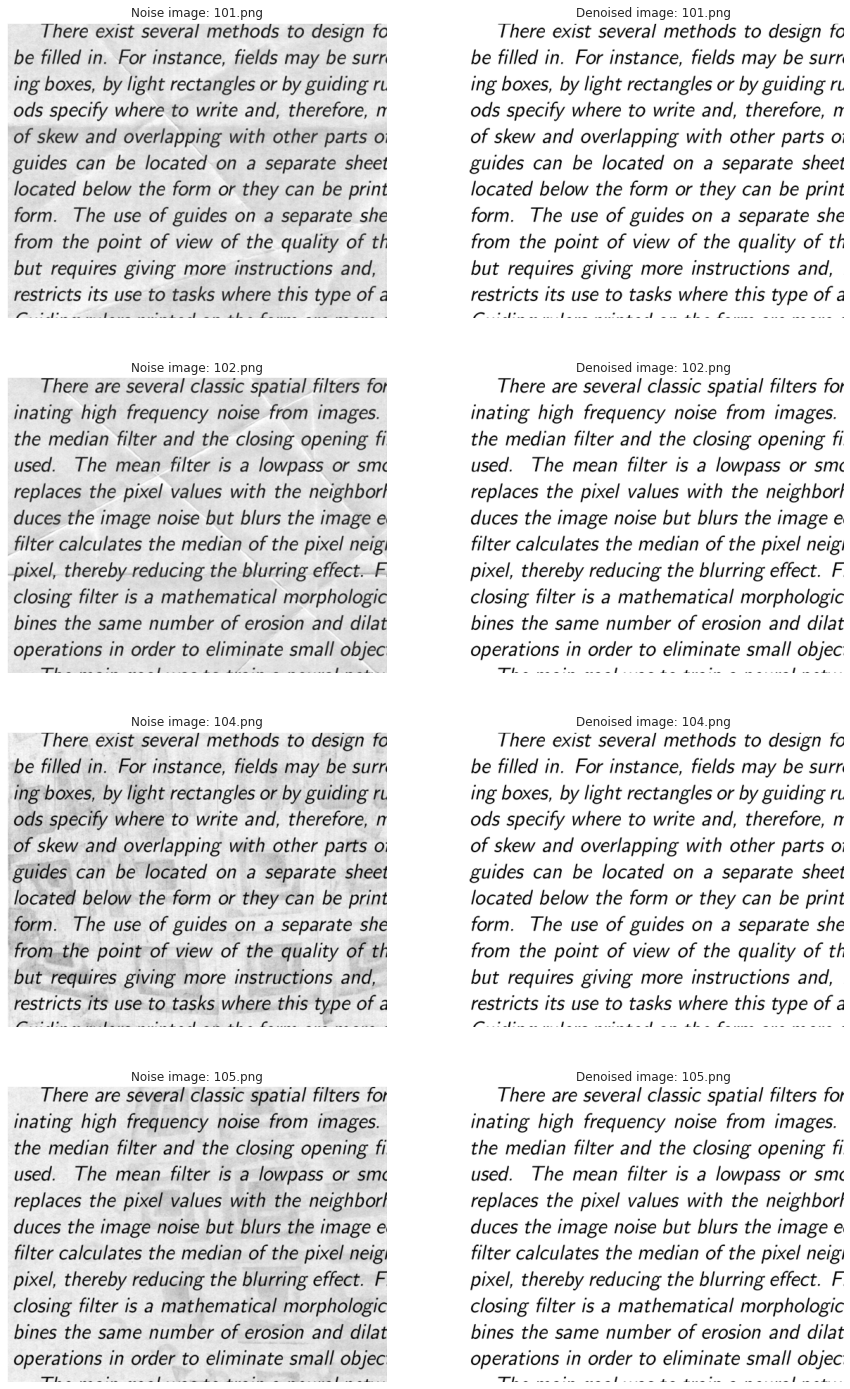

In [14]:
fig, ax = plt.subplots(4, 2, figsize=(15,25))
for i in range(4):
    ax[i][0].imshow(np.squeeze(train[i]), cmap='gray')
    ax[i][0].set_title('Noise image: {}'.format(train_img[i]))
    
    ax[i][1].imshow(np.squeeze(train_cleaned[i]), cmap='gray')
    ax[i][1].set_title('Denoised image: {}'.format(train_img[i]))
    
    ax[i][0].get_xaxis().set_visible(False)
    ax[i][0].get_yaxis().set_visible(False)
    ax[i][1].get_xaxis().set_visible(False)
    ax[i][1].get_yaxis().set_visible(False)

In [15]:
def augment_pipeline(pipeline, images, seed=19):
    ia.seed(seed)
    processed_images = images.copy()
    for step in pipeline:
        temp = np.array(step.augment_images(images))
        processed_images = np.append(processed_images, temp, axis=0)
    return(processed_images)

In [16]:
rotate90 = iaa.Rot90(1) # rotate image 90 degrees
rotate180 = iaa.Rot90(2) # rotate image 180 degrees
rotate270 = iaa.Rot90(3) # rotate image 270 degrees
random_rotate = iaa.Rot90((1,3)) # randomly rotate image from 90,180,270 degrees
perc_transform = iaa.PerspectiveTransform(scale=(0.02, 0.1)) # Skews and transform images without black bg
rotate10 = iaa.Affine(rotate=(10)) # rotate image 10 degrees
rotate10r = iaa.Affine(rotate=(-10)) # rotate image 30 degrees in reverse
crop = iaa.Crop(px=(5, 32)) # Crop between 5 to 32 pixels
hflip = iaa.Fliplr(1) # horizontal flips for 100% of images
vflip = iaa.Flipud(1) # vertical flips for 100% of images
gblur = iaa.GaussianBlur(sigma=(1, 1.5)) # gaussian blur images with a sigma of 1.0 to 1.5
motionblur = iaa.MotionBlur(8) # motion blur images with a kernel size 8

seq_rp = iaa.Sequential([
    iaa.Rot90((1,3)), # randomly rotate image from 90,180,270 degrees
    iaa.PerspectiveTransform(scale=(0.02, 0.1)) # Skews and transform images without black bg
])

seq_cfg = iaa.Sequential([
    iaa.Crop(px=(5, 32)), # crop images from each side by 5 to 32px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 1.5)) # blur images with a sigma of 0 to 1.5
])

seq_fm = iaa.Sequential([
    iaa.Flipud(1), # vertical flips all the images
    iaa.MotionBlur(k=6) # motion blur images with a kernel size 6
])

In [17]:
pipeline = [
    rotate90, rotate180, rotate270, hflip, vflip
]

In [18]:
processed_train = augment_pipeline(pipeline, train)
processed_train_cleaned = augment_pipeline(pipeline, train_cleaned)

processed_train.shape, processed_train_cleaned.shape

((864, 420, 540, 1), (864, 420, 540, 1))

In [19]:
""" Parts of the U-Net model """

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [20]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [21]:
unet = UNet(1,1)

In [22]:
inp = torch.randn((1,1,100,100))

In [23]:
out = unet(inp)

In [24]:
out.shape

torch.Size([1, 1, 100, 100])

In [25]:
# the images are already numpy arrays, and augmentation has
# already been applied
class DenoiseDS(torch.utils.data.Dataset):
  def __init__(self, images, cleaned_images=None, transforms=None):
    self.images = images
    self.gt = cleaned_images
    self.transforms = transforms

  def __len__(self):
    return self.images.shape[0]

  def __getitem__(self, index):
    x = self.images[index]
    if self.gt is not None:
      y = self.gt[index]
    else:
      y = None

    # both the input and cleaned image need the same transform
    if self.transforms is not None:
      x = self.transforms(x)
      if y is not None:
        y = self.transforms(y)

    return (x, y)


In [26]:
common_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=0.5, std=0.5)
])

In [27]:
train_ds = DenoiseDS(images=processed_train, cleaned_images=processed_train_cleaned, transforms=common_transform)

In [28]:
train_iter = iter(train_ds)
data = next(train_iter)

In [29]:
x, y = data
x.shape, y.shape

(torch.Size([1, 420, 540]), torch.Size([1, 420, 540]))

In [30]:
criterion = MSELoss(reduction='mean')
optimizer = SGD(unet.parameters(), lr=0.001, momentum=0.9)

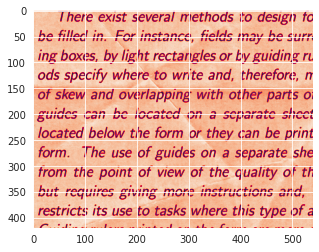

In [31]:
plt.imshow(x.squeeze(0))

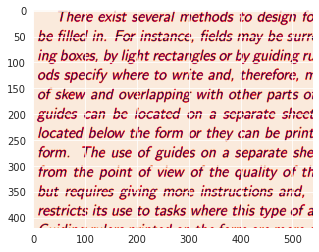

In [32]:
plt.imshow(y.squeeze(0))

In [33]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)

In [ ]:
num_epochs = 10
unet.train()
for epoch in range(num_epochs):
  epoch_loss = 0.0
  for data in tqdm(train_loader):
    x, y = data

    optimizer.zero_grad()

    output = unet(x)

    loss = criterion(output, y)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
  print(f'Epoch {epoch}: loss {epoch_loss:.2f}')

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).plot(ax=ax)
del history

In [ ]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

In [ ]:
decoded_imgs = autoencoder(train[:4]).numpy()
    
fig, ax = plt.subplots(4, 2, figsize=(15,25))
for i in range(4):
    ax[i][0].imshow(tf.squeeze(train_cleaned[i]), cmap='gray')
    ax[i][0].set_title('Denoised image: {}'.format(train_img[i]))
    
    ax[i][1].imshow(tf.squeeze(decoded_imgs[i]), cmap='gray')
    ax[i][1].set_title('Predicted image: {}'.format(train_img[i]))
    
    ax[i][0].get_xaxis().set_visible(False)
    ax[i][0].get_yaxis().set_visible(False)
    ax[i][1].get_xaxis().set_visible(False)
    ax[i][1].get_yaxis().set_visible(False)    

del decoded_imgs    

In [ ]:
ids = []
vals = []
for i, f in tqdm(enumerate(test_img)):
    file = path + 'test/' + f
    imgid = int(f[:-4])
    img = cv2.imread(file, 0)
    img_shape = img.shape
    decoded_img = np.squeeze(autoencoder.decoder(autoencoder.encoder(test[i:i+1]).numpy()).numpy())
    preds_reshaped = cv2.resize(decoded_img, (img_shape[1], img_shape[0]))

    for r in range(img_shape[0]):
        for c in range(img_shape[1]):
            ids.append(str(imgid)+'_'+str(r + 1)+'_'+str(c + 1))
            vals.append(preds_reshaped[r, c])

print('Length of IDs: {}'.format(len(ids)))            
pd.DataFrame({'id': ids, 'value': vals}).to_csv('submission.csv',index=False)
print('Results saved to submission.csv!')
